План ноутбука:
- загрузить данные 
- график за все время
- распределение значений
- tss time series split
- добавить временных фич в дачату 
- добавить некоторые лаги 
- 




In [30]:
import pandas as pd 
import numpy as np 
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

## 1. Prepare data
### 1.1 Read data

In [6]:
df = pd.read_csv('../data/MPS_actions/use_force/UF_aggregated_22_23.csv', index_col=0)

In [7]:
df.head()

,IncidentDate,Borough,counts
0,2022-04-01,Barking and Dagenham,9
1,2022-04-01,Barnet,7
2,2022-04-01,Bexley,5
3,2022-04-01,Brent,12
4,2022-04-01,Bromley,19


### 1.2 Detect missing borough 

In [8]:
unique_dates = df['IncidentDate'].unique()
unique_boroughs = df['Borough'].unique()    

In [31]:
print(unique_dates.shape, unique_boroughs.shape)

(365,) (34,)


In [9]:
missed_data = []
for d,b in product(unique_dates,unique_boroughs):
    if df[(df['IncidentDate'] == d)&(df['Borough'] == b)].empty:
        missed_data.append({
            'IncidentDate' :d,
            'Borough':b,
            'counts':0            
        })

### 1.3 Add missing values

In [10]:
df_missed_data = pd.DataFrame(missed_data)
df_missed_data.head()

,IncidentDate,Borough,counts
0,2022-04-01,Kingston upon Thames,0
1,2022-04-01,Heathrow,0
2,2022-04-02,Heathrow,0
3,2022-04-06,Kensington and Chelsea,0
4,2022-04-08,Richmond upon Thames,0


In [11]:
full_df = pd.concat([df, df_missed_data], ignore_index=True )

In [12]:
full_df.head()

,IncidentDate,Borough,counts
0,2022-04-01,Barking and Dagenham,9
1,2022-04-01,Barnet,7
2,2022-04-01,Bexley,5
3,2022-04-01,Brent,12
4,2022-04-01,Bromley,19


In [13]:
full_df.tail()

,IncidentDate,Borough,counts
12405,2023-03-26,Out of force,0
12406,2023-03-26,Richmond upon Thames,0
12407,2023-03-26,Heathrow,0
12408,2023-03-27,Out of force,0
12409,2023-03-27,Heathrow,0


In [14]:
full_df.sort_values(by=['IncidentDate','Borough'],inplace=True,ignore_index=True)
full_df.head()

,IncidentDate,Borough,counts
0,2022-04-01,Barking and Dagenham,9
1,2022-04-01,Barnet,7
2,2022-04-01,Bexley,5
3,2022-04-01,Brent,12
4,2022-04-01,Bromley,19


Todo: save full data

### 1.4 IncidentDate tto datetime format 

In [15]:
df = full_df
df = df.set_index('IncidentDate')
df.index = pd.to_datetime(df.index)

In [16]:
df.head()

,Borough,counts
IncidentDate,,
2022-04-01,Barking and Dagenham,9
2022-04-01,Barnet,7
2022-04-01,Bexley,5
2022-04-01,Brent,12
2022-04-01,Bromley,19


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12410 entries, 2022-04-01 to 2023-03-31
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Borough  12410 non-null  object
 1   counts   12410 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 290.9+ KB


## 2. Looking for Outliers

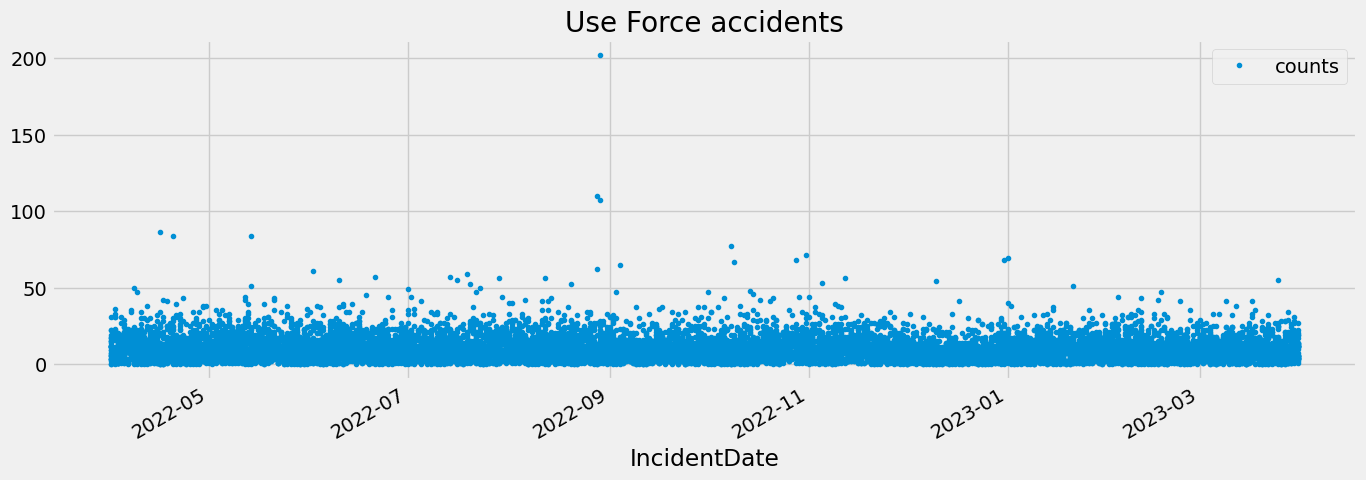

In [18]:
df.plot(style='.',figsize=(15,5),
        color=color_pal[0],
        title='Use Force accidents')
plt.show()

<Axes: ylabel='Frequency'>

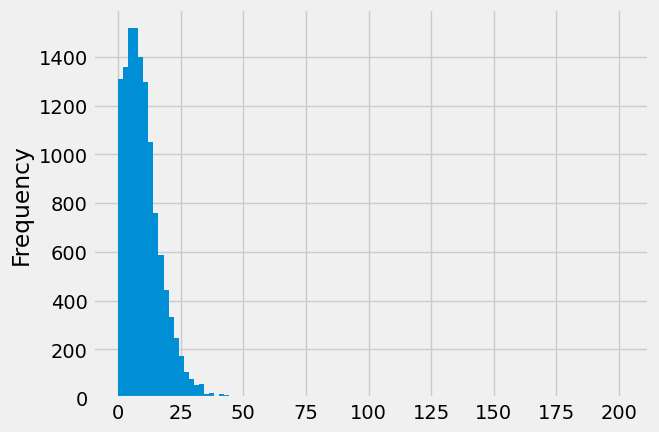

In [21]:
df['counts'].plot(kind='hist', bins=100)

<Axes: title={'center': 'Hight values'}, xlabel='IncidentDate'>

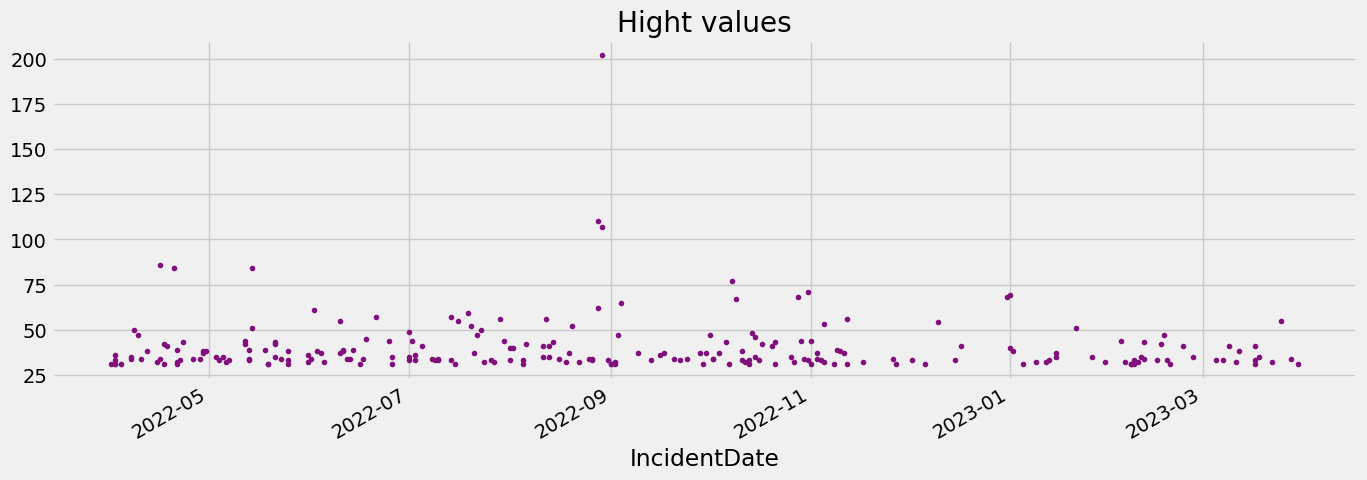

In [25]:
df.query('counts > 30')['counts'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Hight values')

## 3. Time Series Cross Validation

In [32]:
tss = TimeSeriesSplit(n_splits=5, test_size = 30*34, gap=34)
df = df.sort_index()

In [34]:
df.head()

,Borough,counts
IncidentDate,,
2022-04-01,Barking and Dagenham,9
2022-04-01,Barnet,7
2022-04-01,Bexley,5
2022-04-01,Brent,12
2022-04-01,Bromley,19


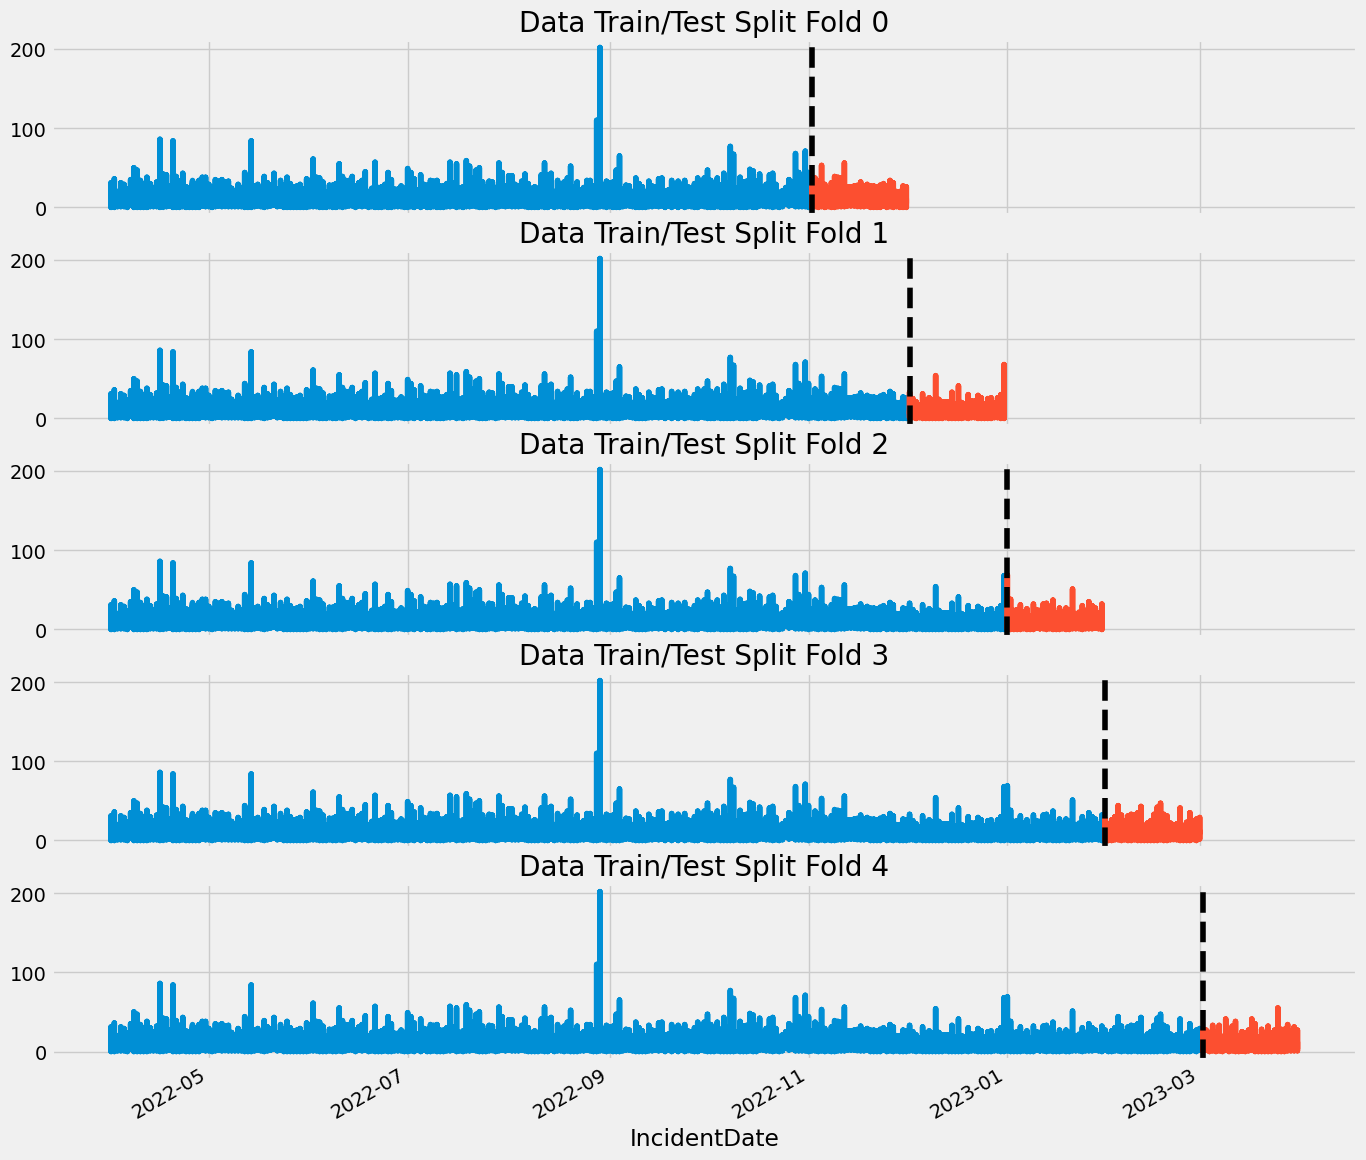

In [35]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['counts'].plot(ax=axs[fold],label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['counts'].plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## 4. Feastures

### 4.1 else one split (not tss)

In [61]:
data_train = df.loc[df.index < '2023-02-15']
data_test = df.loc[df.index >= '2023-02-15']  

### 4.2 Borough as a feature

In [73]:
def make_new_ohe(df_train, object_cols=['Borough']):
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, feature_name_combiner= lambda x,y: str(y))
    # object_cols = ['Borough']
    df = df_train.copy()
    OH_cols_df = pd.DataFrame(OH_encoder.fit_transform(df[object_cols]))
    OH_cols_df.index = df.index
    OH_cols_df.columns = OH_encoder.get_feature_names_out(object_cols)
    OH_cols_df.columns = OH_cols_df.columns.astype(str)
    ohe_df = pd.concat([df.drop(object_cols, axis=1), OH_cols_df], axis=1)
    return ohe_df, OH_encoder

def make_oh_encoding(df_test, oh_encoder, object_cols=['Borough']):
    df = df_test.copy()
    OH_cols_df = pd.DataFrame(oh_encoder.transform(df[object_cols]))
    OH_cols_df.index = df.index
    OH_cols_df.columns = oh_encoder.get_feature_names_out(object_cols)
    OH_cols_df.columns = OH_cols_df.columns.astype(str)
    ohe_df = pd.concat([df.drop(object_cols, axis=1), OH_cols_df], axis=1)
    return ohe_df

object_cols = ['Borough']

train, my_oh_encoder = make_new_ohe(data_train)
test  = make_oh_encoding(data_test, my_oh_encoder)

g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [63]:
train

,counts,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of Westminster,Croydon,Ealing,...,Merton,Newham,Out of force,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth
IncidentDate,,,,,,,,,,,,,,,,,,,,,
2022-04-01,9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-01,7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-01,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-01,12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-01,19,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-14,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2023-02-14,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2023-02-14,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [64]:
test

,counts,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of Westminster,Croydon,Ealing,...,Merton,Newham,Out of force,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth
IncidentDate,,,,,,,,,,,,,,,,,,,,,
2023-02-15,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-15,9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-15,12,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-15,9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-15,9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2023-03-31,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2023-03-31,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [65]:
# OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, feature_name_combiner= lambda x,y: str(y))
# object_cols = ['Borough']
# OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(data_train[object_cols]))
# OH_cols_valid = pd.DataFrame(OH_encoder.transform(data_valid[object_cols]))
# OH_cols_train.index = data_train.index
# OH_cols_valid.index = data_valid.index
# OH_cols_train.columns = OH_encoder.get_feature_names_out(object_cols)
# OH_cols_valid.columns = OH_encoder.get_feature_names_out(object_cols)

# num_data_train = data_train.drop(object_cols, axis=1)
# num_data_valid = data_valid.drop(object_cols, axis=1)


# OH_X_train = pd.concat([num_data_train, OH_cols_train], axis=1)
# OH_X_valid = pd.concat([num_data_valid, OH_cols_valid], axis=1)

### 4.3 Forecasting Horizon Explained

In [66]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

train = create_features(train)
test = create_features(test)

In [67]:
train

,counts,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of Westminster,Croydon,Ealing,...,Waltham Forest,Wandsworth,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
IncidentDate,,,,,,,,,,,,,,,,,,,,,
2022-04-01,9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,4,2,4,2022,91,1,13
2022-04-01,7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,4,2,4,2022,91,1,13
2022-04-01,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,4,2,4,2022,91,1,13
2022-04-01,12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,4,2,4,2022,91,1,13
2022-04-01,19,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,4,2,4,2022,91,1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-14,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1,1,2,2023,45,14,7
2023-02-14,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1,1,2,2023,45,14,7
2023-02-14,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1,1,2,2023,45,14,7


In [68]:
test

,counts,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of Westminster,Croydon,Ealing,...,Waltham Forest,Wandsworth,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
IncidentDate,,,,,,,,,,,,,,,,,,,,,
2023-02-15,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,2,1,2,2023,46,15,7
2023-02-15,9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,2,1,2,2023,46,15,7
2023-02-15,12,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,2,1,2,2023,46,15,7
2023-02-15,9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,2,1,2,2023,46,15,7
2023-02-15,9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,2,1,2,2023,46,15,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,4,1,3,2023,90,31,13
2023-03-31,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,4,1,3,2023,90,31,13
2023-03-31,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,4,1,3,2023,90,31,13


### 4.4 Lag Features
need rewrite prediction function

In [69]:
df.head()

,Borough,counts
IncidentDate,,
2022-04-01,Barking and Dagenham,9
2022-04-01,Barnet,7
2022-04-01,Bexley,5
2022-04-01,Brent,12
2022-04-01,Bromley,19


In [70]:
df.tail()

,Borough,counts
IncidentDate,,
2023-03-31,Southwark,19
2023-03-31,Sutton,2
2023-03-31,Tower Hamlets,11
2023-03-31,Waltham Forest,4
2023-03-31,Wandsworth,3


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12410 entries, 2022-04-01 to 2023-03-31
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Borough  12410 non-null  object
 1   counts   12410 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 290.9+ KB


## 5. Train Using Cross Validation

### 5.1 Home made metrics

In [80]:
def wmape(y_true, y_pred):
    return 100*np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [81]:
def smape(y_true, y_pred):
    eps = np.ones_like(y_true)*0.1
    return (np.abs(y_true - y_pred) / np.max([y_true,y_pred,eps],axis=0)).sum()*(100/np.max(y_true.shape))

### 5.2 Cross Validation

Try to read about [objective][1] in XGBRegressor

[1]: https://xgboost.readthedocs.io/en/stable/parameter.html

In [85]:
tss = TimeSeriesSplit(n_splits=5, test_size=30*34, gap=0)


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train, my_oh_encoder = make_new_ohe(train)
    test  = make_oh_encoding(test, my_oh_encoder)
    train = create_features(train)
    test = create_features(test)
    
    
    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year']
    TARGET = 'counts'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    
    # Xgboost
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=4,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    score_mape = mean_absolute_percentage_error(y_test, y_pred)
    score_wmape = wmape(y_test, y_pred)
    score_smape = smape(y_test, y_pred)
    
    scores.append({'rmse':score_rmse, 'mape':score_mape, 'wmape':score_wmape, 'smape':score_smape})
    

[0]	validation_0-rmse:13.47701	validation_1-rmse:12.17496


[100]	validation_0-rmse:9.20889	validation_1-rmse:7.68441


g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated 

[200]	validation_0-rmse:8.45587	validation_1-rmse:7.24653
[281]	validation_0-rmse:8.34938	validation_1-rmse:7.25178
[0]	validation_0-rmse:13.32572	validation_1-rmse:9.86547
[100]	validation_0-rmse:9.06743	validation_1-rmse:6.61074
[200]	validation_0-rmse:8.31787	validation_1-rmse:6.28098
[270]	validation_0-rmse:8.22028	validation_1-rmse:6.27968


g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future vers

[0]	validation_0-rmse:12.99498	validation_1-rmse:11.64138
[100]	validation_0-rmse:8.86593	validation_1-rmse:7.36103
[200]	validation_0-rmse:8.12938	validation_1-rmse:6.87819
[272]	validation_0-rmse:8.02933	validation_1-rmse:6.88182


g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future vers

[0]	validation_0-rmse:12.86917	validation_1-rmse:11.92063
[100]	validation_0-rmse:8.74940	validation_1-rmse:7.85552
[200]	validation_0-rmse:8.01778	validation_1-rmse:7.15191


g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future vers

[300]	validation_0-rmse:7.90419	validation_1-rmse:7.04450
[400]	validation_0-rmse:7.88139	validation_1-rmse:7.02860
[500]	validation_0-rmse:7.87429	validation_1-rmse:7.02631
[600]	validation_0-rmse:7.86947	validation_1-rmse:7.02649
[606]	validation_0-rmse:7.86929	validation_1-rmse:7.02662
[0]	validation_0-rmse:12.78702	validation_1-rmse:11.65222
[100]	validation_0-rmse:8.67310	validation_1-rmse:7.43438
[200]	validation_0-rmse:7.94208	validation_1-rmse:6.85509


g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future vers

[300]	validation_0-rmse:7.82973	validation_1-rmse:6.84078
[301]	validation_0-rmse:7.82926	validation_1-rmse:6.84102


g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
g:\github_projects\neighbourhood-safety-prediction\venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future vers

In [86]:
# print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores')
for score in scores:
    print(score)
    

Fold scores
{'rmse': 7.237872219639248, 'mape': 781826219711003.1, 'wmape': 53.52695418457835, 'smape': 40.462208714254565}
{'rmse': 6.275623488418185, 'mape': 1151253435651093.0, 'wmape': 55.628112479981986, 'smape': 41.620939387599755}
{'rmse': 6.873568168766064, 'mape': 962251850233784.6, 'wmape': 52.02066056813546, 'smape': 39.83393305142042}
{'rmse': 7.026067769629418, 'mape': 1106121578233792.5, 'wmape': 52.05048266217302, 'smape': 39.63088277698156}
{'rmse': 6.832496528262553, 'mape': 1201796745534493.0, 'wmape': 52.78220667915628, 'smape': 40.4852979471388}
